## Packages & utils

In [1]:
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm
import holidays

from sklearn.metrics import mean_squared_error

fr_holidays = holidays.CountryHoliday('FRA')

from vacances_scolaires_france import SchoolHolidayDates
school_holidays = SchoolHolidayDates()

## Données

In [2]:
nomenclature_produits = pd.read_csv('data/nomenclature_produits.csv')

points_de_vente = pd.read_csv('data/points_de_vente.csv')
prix_vente = pd.read_csv('data/prix_vente.csv')

prix_vente['ORD_PRIX'] = prix_vente['PRIX_UNITAIRE'].apply(lambda x: float(x.split(' ')[-1].replace('€', '')))

ventes_2018 = pd.read_csv('data/ventes_2018.csv.zip',
                          parse_dates=['DATE'])

In [3]:
artc_list = ventes_2018['ID_ARTC'].drop_duplicates().tolist()
pdv_list = ventes_2018['ID_PDV'].drop_duplicates().tolist()

In [4]:
dates = pd.date_range('2018-01-01', '2019-03-31')
combines = pd.DataFrame(itertools.product(artc_list, dates),
                        columns=['ID_ARTC', 'DATE']
                        )

In [5]:
dates_dataframe = combines[['DATE']].drop_duplicates()
dates_dataframe['holiday_zone_A'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'A'))
dates_dataframe['holiday_zone_B'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'B'))
dates_dataframe['holiday_zone_C'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'C'))

In [6]:
import warnings
warnings.filterwarnings("ignore")

## PDV model

In [7]:
from sklearn.linear_model import Ridge 
from sklearn.ensemble import StackingRegressor, BaggingRegressor

from catboost import CatBoostRegressor

In [33]:
errors_list = list()
test_list = list()

for pdv in tqdm(pdv_list):
    # extract data and add empty dates
    sub_ventes = ventes_2018.query(f'ID_PDV=={pdv}')\
                          .drop('ID_PDV', axis=1)\
                          .merge(combines, how='right')\
                          .fillna({'QTE': 0})
    
    # add products infos
    sub_ventes['TRIMESTRE'] = sub_ventes['DATE'].dt.quarter
    sub_ventes['ANNEE'] = sub_ventes['DATE'].dt.year

    sub_ventes = sub_ventes.merge(nomenclature_produits, how='right')
    sub_ventes = sub_ventes.merge(prix_vente.query(f'ID_PDV=={pdv}')\
                                          .filter(
                                              ['ID_ARTC', 'ANNEE', 'TRIMESTRE', 'ORD_PRIX', 'PRIX_UNITAIRE']
                                              ),
                                  how='left'
                                          )
    
    
    # remove products without any sale
#    prod_to_rm = sub_ventes.groupby('ID_ARTC')['QTE'].sum().reset_index().query('QTE==0')['ID_ARTC'].tolist()
#    sub_ventes = sub_ventes[~sub_ventes['ID_ARTC'].isin(prod_to_rm)]

    # price compare
    price_table = sub_ventes.groupby(['DATE', 'LB_VENT_FAML'])['ORD_PRIX']\
          .value_counts(normalize=True)\
          .reset_index(name='tmp').drop('tmp', axis=1)\
          .groupby(['DATE', 'LB_VENT_FAML']).head(1)\
          .reset_index(drop=True).rename(columns={'ORD_PRIX': 'COMMON_PRICE'})
    
    sub_ventes = sub_ventes.merge(price_table, how='left')
    sub_ventes['PRICE_INDEX'] = (sub_ventes['ORD_PRIX']/sub_ventes['COMMON_PRICE'])\
                                .apply(lambda x: 'lower' if x<1 else ('higher' if x>1 else 'equal'))
    
    # extract date 
    sub_ventes['WEEK_DAY'] = sub_ventes['DATE'].dt.dayofweek
    sub_ventes['DAY_OF_MONTH'] = sub_ventes['DATE'].dt.day
    sub_ventes['HOLIDAYS'] = sub_ventes['DATE'].apply(lambda x: x in fr_holidays)
    sub_ventes = sub_ventes.merge(dates_dataframe)
    
    # create target
    sub_ventes['LOG_QTE'] = np.log1p(sub_ventes['QTE'])
    
    # encode categories
    sub_ventes['ID_ARTC'] = sub_ventes['ID_ARTC'].astype('category')
    sub_ventes['LB_VENT_RAYN'] = sub_ventes['LB_VENT_RAYN'].astype('category')
    sub_ventes['LB_VENT_FAML'] = sub_ventes['LB_VENT_FAML'].astype('category')
    sub_ventes['LB_VENT_SOUS_FAML'] = sub_ventes['LB_VENT_SOUS_FAML'].astype('category')
    sub_ventes['WEEK_DAY'] = sub_ventes['WEEK_DAY'].astype('category')
    sub_ventes['PRICE_INDEX'] = sub_ventes['PRICE_INDEX'].fillna('UNK').astype('category')

    # create train, val & test
    train = sub_ventes.query('ANNEE==2018 and TRIMESTRE<4')
    val = sub_ventes.query('ANNEE==2018 and TRIMESTRE==4')
    test = sub_ventes.query('ANNEE==2019 and TRIMESTRE==1')
    
    # train, valid
    cols = ['ID_ARTC', 'LB_VENT_RAYN', 'LB_VENT_FAML', 'LB_VENT_SOUS_FAML',
            'PRICE_INDEX',
            'WEEK_DAY', 'DAY_OF_MONTH', 'HOLIDAYS', 
            'holiday_zone_A', 'holiday_zone_B', 'holiday_zone_C',
            'ORD_PRIX'
            ]
    target = 'LOG_QTE'
    
    model_lightgbm = lightgbm.LGBMRegressor(
        objective='regression_l2',
        n_estimators=100,
        random_state=3105, n_jobs=-1)
    
#    model_catboost = CatBoostRegressor(
#        n_estimators=150, random_state=3105,
#        cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], verbose=False
#    )
    
    model_lightgbm.fit(train[cols], train[target])
    #model_catboost.fit(train[cols], train[target])

    val.loc[:,'preds'] = model_lightgbm.predict(val[cols])#*0.5 + model_catboost.predict(val[cols])*0.5).clip(0)
    
    errors_list.append(np.sqrt(mean_squared_error(val['LOG_QTE'], val['preds'])))
    print(pdv, errors_list[-1])
    
    # re-train
    full_train = sub_ventes.query('ANNEE==2018 and TRIMESTRE<=4')
        
    model_lightgbm.fit(full_train[cols], full_train[target])
    #model_catboost.fit(full_train[cols], full_train[target])
    
    test.loc[:,'preds'] = model_lightgbm.predict(test[cols])#*0.5 + model_catboost.predict(test[cols])*0.5).clip(0)
    test['ID_PDV'] = pdv
    
    test_list.append(test)

  0%|          | 0/149 [00:00<?, ?it/s]

102 0.3903125670183636


  1%|          | 1/149 [00:22<55:23, 22.45s/it]

5 0.303472061814166


  1%|          | 1/149 [00:39<1:38:30, 39.94s/it]


KeyboardInterrupt: 

In [9]:
np.mean(errors_list)

0.40564156017967884

In [31]:
errors_list

[0.39938809821371113,
 0.30174495404875445,
 0.4252814301384088,
 0.3938084764330058,
 0.5398875002512612,
 0.4867613651423813,
 0.43710964909219663,
 0.38845642722793833,
 0.4721106821571182,
 0.44345856461197847,
 0.25507797190973586,
 0.4766050243265567,
 0.500038265304032,
 0.40859638135929693,
 0.41302987682675835,
 0.4407287568638606,
 0.3784115073866522,
 0.36507662183904044,
 0.3168284066594765,
 0.43595818294925576,
 0.3246707594041865,
 0.4139472242740266,
 0.532570734690865,
 0.35646706986069226,
 0.5423997318090253,
 0.38869206318141225,
 0.4110122129499107,
 0.41112233869738835,
 0.6055189583104923,
 0.531809265761711,
 0.3902875866937196,
 0.3899627892576616,
 0.33054633216384816,
 0.38184306480402896,
 0.47086364186451624,
 0.4593371294567678,
 0.44560003868609466,
 0.4528719032822338,
 0.5056797190556654,
 0.47804275741537244,
 0.3484410154396597,
 0.4825768787492057,
 0.5410186865484123,
 0.5014002393846132,
 0.5075775243320372,
 0.34477790053902657,
 0.385924390886392

In [10]:
submission_file = pd.concat(test_list)

In [11]:
submission_file['raw_qte'] = np.expm1(submission_file['preds'].clip(0))
submission_file['qte'] = np.expm1(submission_file['preds'].clip(0)).round().astype(int)
submission_file['id'] = submission_file['ID_PDV'].astype(str) + "_" + \
                        submission_file['ID_ARTC'].astype(str) + '_' + \
                        submission_file['DATE'].dt.strftime('%Y%m%d').astype(str)

In [12]:
submission_file[['id', 'qte', 'raw_qte']].head()

,id,qte,raw_qte
912500,102_905_20190101,0,0.063775
912501,102_477_20190101,0,0.000000
912502,102_863_20190101,0,0.000000
912503,102_1741_20190101,0,0.086159
912504,102_983_20190101,0,0.054615


In [13]:
submission_file.query('qte!=0')[['id', 'qte']].to_csv('submit_3.csv.zip', index=False, compression="zip")

In [14]:
submission_file[['id', 'qte', 'raw_qte']].to_csv('submit_3_raw.csv.zip', index=False, compression="zip")

In [29]:
submission_file.sample()

,ID_ARTC,DATE,QTE,TRIMESTRE,ANNEE,LB_VENT_RAYN,LB_VENT_FAML,LB_VENT_SOUS_FAML,ORD_PRIX,PRIX_UNITAIRE,...,HOLIDAYS,holiday_zone_A,holiday_zone_B,holiday_zone_C,LOG_QTE,preds,ID_PDV,raw_qte,qte,id
978400,952,2019-01-27,0.0,1,2019,PAIN PAT LS INDUS,PATISSERIE LS TRADITIONNELLE,PATISSERIE LS TRADITIONNELLE - SS-FAML 3,NaN,NaN,...,False,False,False,False,0.0,-0.014194,131,0.0,0,131_952_20190127


<AxesSubplot:xlabel='DATE'>

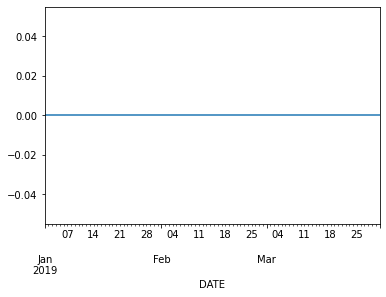

In [30]:
submission_file.query('ID_ARTC==952 and ID_PDV==131').set_index('DATE')['qte'].plot()